In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflowjs as tfjs


In [2]:
directory = '/Users/esens/Python/SearchNBlogWithoutAds_Crawler'
train_dir = directory+'/train'
validation_dir = directory+'/validation'

train_image_dir = os.path.join(train_dir, 'image')  
train_advertise_dir = os.path.join(train_dir, 'advertise')  

validation_image_dir = os.path.join(validation_dir, 'image')
validation_advertise_dir = os.path.join(validation_dir, 'advertise')


In [3]:

num_image_tr = len(os.listdir(train_image_dir))
num_advertise_tr = len(os.listdir(train_advertise_dir))

num_image_val = len(os.listdir(validation_image_dir))
num_advertise_val = len(os.listdir(validation_advertise_dir))

total_train = num_image_tr + num_advertise_tr
total_val = num_image_val + num_advertise_val

In [4]:
print('total training image images:', num_image_tr)
print('total training advertise images:', num_advertise_tr)
print('num_image_tr : ' , num_image_tr);

print('total validation image images:', num_image_val)
print('total validation advertise images:', num_advertise_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training image images: 41
total training advertise images: 41
num_image_tr :  41
total validation image images: 8
total validation advertise images: 8
--
Total training images: 82
Total validation images: 16


In [5]:
batch_size = 8
epochs = 15
IMG_HEIGHT = 120
IMG_WIDTH = 360

In [6]:
#for training data 
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 80 images belonging to 2 classes.


In [7]:
#for validation data 
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 14 images belonging to 2 classes.


In [8]:
sample_training_images, _ = next(train_data_gen)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

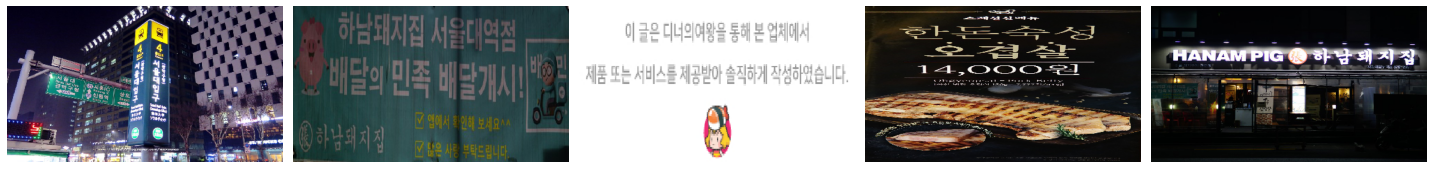

In [10]:
plotImages(sample_training_images[:5])
# create the model
def create_model():
    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [11]:
model = create_model();
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 260, 460, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 130, 230, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 230, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 65, 115, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 115, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 57, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 116736)            0

In [12]:
# 모델 저장
checkpoint_path = "model_diff_width_0707_v1(batch-24)/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # 15번째 에포크에서 저장
    period=15)
checkpoint_path

'model_diff_width_0707_v1(batch-24)/cp-{epoch:04d}.ckpt'

In [13]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    callbacks =[cp_callback],
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
 4/10 [===========>..................] - ETA: 2s - loss: 1.9283 - accuracy: 0.5938

KeyboardInterrupt: 

In [ ]:
! ls {checkpoint_dir}
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
PATH =directory + "/test"

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory=str(PATH),
                                                batch_size=batch_size,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')
print("test_data_gen : " , test_data_gen)
print(test_data_gen.labels)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

# create model
model = create_model()
model.load_weights(latest)
tfjs.converters.save_keras_model(model, "tfjs_model")

In [ ]:
my_img_path = directory + "/test/image/3.jpg"
image = tf.keras.preprocessing.image.load_img(my_img_path,target_size=(IMG_HEIGHT, IMG_WIDTH))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

#print("model shape : " , model.summary());
# print("input_arr : ", input_arr)

predictions_class = model.predict_classes(input_arr)
predictions = model.predict(input_arr)

print("========pridiction========")
print(test_data_gen.class_indices)
print("predictions class : " , predictions_class);
print("predictions class : " , predictions_class[0][0]);
print("predictions : " , predictions);
print("predictions argmax : ",np.argmax(predictions[0])); # same way
if predictions_class > 0:
    if "image" in my_img_path:
        print("correct!")
    else:
        print("not correct....")
else:
    if "advertise" in my_img_path:
        print("correct!")
    else:
        print("not correct....")
    